In [ ]:
import random

class BlackjackEnv5Decks:
    def __init__(self, num_decks=5):
        self.num_decks = num_decks
        self.build_shoe()
        self.player = []
        self.dealer = []
        self.done = False
        self.reward = 0.0


    # Build & manage the card shoe

    def build_shoe(self):

        one_deck = [1,2,3,4,5,6,7,8,9,10,10,10,10]  # 13 cards
        self.shoe = one_deck * (4 * self.num_decks)  # 52 cards per deck
        random.shuffle(self.shoe)

    def draw_card(self):
        """
        Draws a card from the shoe. If shoe is low, reshuffle a new shoe.
        """
        if len(self.shoe) < 15:  # reshuffle threshold
            self.build_shoe()
        return self.shoe.pop()

    # Hand evaluation

    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]

    def hand_value_and_usable_ace(self, hand):
        total = sum(hand)
        ace_count = hand.count(1)
        usable_ace = False

        if ace_count > 0 and total + 10 <= 21:
            total += 10
            usable_ace = True

        return total, usable_ace


    # Environment API

    def reset(self):
        self.done = False
        self.reward = 0.0

        self.player = self.draw_hand()
        self.dealer = self.draw_hand()

        player_sum, usable_ace = self.hand_value_and_usable_ace(self.player)
        dealer_card = self.dealer[0]

        return (player_sum, dealer_card, usable_ace)

    def step(self, action):
        if self.done:
            raise ValueError("Game is over. Call reset().")

        if action == "hit":
            self.player.append(self.draw_card())
            player_sum, usable_ace = self.hand_value_and_usable_ace(self.player)

            if player_sum > 21:
                self.done = True
                self.reward = -1.0
                return (player_sum, self.dealer[0], usable_ace), self.reward, self.done

            return (player_sum, self.dealer[0], usable_ace), 0.0, False

        elif action == "stand":
            player_sum, _ = self.hand_value_and_usable_ace(self.player)

            dealer_sum, _ = self.hand_value_and_usable_ace(self.dealer)
            while dealer_sum < 17:
                self.dealer.append(self.draw_card())
                dealer_sum, _ = self.hand_value_and_usable_ace(self.dealer)

            self.done = True
            if dealer_sum > 21 or player_sum > dealer_sum:
                self.reward = +1.0
            elif player_sum < dealer_sum:
                self.reward = -1.0
            else:
                self.reward = 0.0

            usable_ace = self.hand_value_and_usable_ace(self.player)[1]
            return (player_sum, self.dealer[0], usable_ace), self.reward, True

        else:
            raise ValueError("Action must be 'hit' or 'stand'.")


In [ ]:
env = BlackjackEnv5Decks()

def test_policy(state):
    # simple placeholder: hit < 17
    player_sum, dealer_card, usable_ace = state
    return "hit" if player_sum < 17 else "stand"

for i in range(3):
    state = env.reset()
    print(f"\n--- Game {i+1} ---")
    print("Initial:", state)
    done = False
    while not done:
        action = test_policy(state)
        next_state, reward, done = env.step(action)
        print(f"Action={action}, Next={next_state}, Reward={reward}, Done={done}")
        state = next_state



--- Game 1 ---
Initial: (12, 10, False)
Action=hit, Next=(17, 10, False), Reward=0.0, Done=False
Action=stand, Next=(17, 10, False), Reward=-1.0, Done=True

--- Game 2 ---
Initial: (11, 1, False)
Action=hit, Next=(16, 1, False), Reward=0.0, Done=False
Action=hit, Next=(18, 1, False), Reward=0.0, Done=False
Action=stand, Next=(18, 1, False), Reward=-1.0, Done=True

--- Game 3 ---
Initial: (17, 10, False)
Action=stand, Next=(17, 10, False), Reward=-1.0, Done=True


In [ ]:

from google.colab import drive
import sqlite3

drive.mount('/content/drive')


db_path = "/content/drive/MyDrive/blackjack_mc.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

print(" Connected to database at:", db_path)

# 'games' table
cursor.execute("""
CREATE TABLE IF NOT EXISTS games (
    game_id      INTEGER PRIMARY KEY AUTOINCREMENT,
    final_reward REAL,
    num_steps    INTEGER,
    timestamp    DATETIME DEFAULT CURRENT_TIMESTAMP
)
""")

# 'steps' table
cursor.execute("""
CREATE TABLE IF NOT EXISTS steps (
    step_id     INTEGER PRIMARY KEY AUTOINCREMENT,
    game_id     INTEGER,
    step_num    INTEGER,
    player_sum  INTEGER,
    dealer_card INTEGER,
    usable_ace  INTEGER,
    action      TEXT,
    reward      REAL,
    FOREIGN KEY (game_id) REFERENCES games(game_id)
)
""")

# 'qvalues' table
cursor.execute("""
CREATE TABLE IF NOT EXISTS qvalues (
    state_player_sum   INTEGER,
    state_dealer_card  INTEGER,
    state_usable_ace   INTEGER,   -- 0 or 1
    action             TEXT,
    q_value            REAL,
    PRIMARY KEY (state_player_sum, state_dealer_card, state_usable_ace, action)
)
""")

conn.commit()
print(" Tables ready: games, steps, qvalues")


Mounted at /content/drive
 Connected to database at: /content/drive/MyDrive/blackjack_mc.db
 Tables ready: games, steps, qvalues


In [ ]:

#  MONTE CARLO + PERSISTENT Q-VALUES

import random
from collections import defaultdict

ACTIONS = ["hit", "stand"]

# Save / load Q from the DB

def save_q_to_db(Q, conn):
    cursor = conn.cursor()
    # Clear old Q-values
    cursor.execute("DELETE FROM qvalues")

    rows = []
    for state, action_dict in Q.items():
        player_sum, dealer_card, usable_ace = state
        usable_ace_int = 1 if usable_ace else 0
        for action, q_val in action_dict.items():
            rows.append((player_sum, dealer_card, usable_ace_int, action, float(q_val)))

    cursor.executemany("""
        INSERT INTO qvalues (
            state_player_sum, state_dealer_card,
            state_usable_ace, action, q_value
        ) VALUES (?, ?, ?, ?, ?)
    """, rows)

    conn.commit()
    print(f" Saved {len(rows)} Q-values to the database.")


def load_q_from_db(conn):
    cursor = conn.cursor()
    cursor.execute("""
        SELECT state_player_sum, state_dealer_card,
               state_usable_ace, action, q_value
        FROM qvalues
    """)
    rows = cursor.fetchall()

    Q = defaultdict(lambda: {a: 0.0 for a in ACTIONS})

    for player_sum, dealer_card, usable_ace_int, action, q_val in rows:
        state = (player_sum, dealer_card, bool(usable_ace_int))
        if state not in Q:
            Q[state] = {a: 0.0 for a in ACTIONS}
        Q[state][action] = q_val

    policy = {}
    for state, action_dict in Q.items():
        best_action = max(action_dict, key=action_dict.get)
        policy[state] = best_action

    print(f" Loaded {len(policy)} states from qvalues.")
    return Q, policy


# action selection

def choose_action(state, Q, epsilon):
    if random.random() < epsilon or state not in Q:
        return random.choice(ACTIONS)
    q_s = Q[state]
    max_q = max(q_s.values())
    best_actions = [a for a, q in q_s.items() if q == max_q]
    return random.choice(best_actions)


# Generate one episode

def generate_episode(env, Q, epsilon):
    episode = []
    state = env.reset()
    done = False
    while not done:
        action = choose_action(state, Q, epsilon)
        next_state, reward, done = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode


# Log an episode into games/steps
def log_episode_to_db(conn, episode):
    if len(episode) == 0:
        return

    cursor = conn.cursor()
    final_reward = episode[-1][2]
    num_steps = len(episode)

    cursor.execute(
        "INSERT INTO games (final_reward, num_steps) VALUES (?, ?)",
        (final_reward, num_steps)
    )
    game_id = cursor.lastrowid

    for step_num, (state, action, reward) in enumerate(episode):
        player_sum, dealer_card, usable_ace = state
        cursor.execute("""
            INSERT INTO steps (
                game_id, step_num, player_sum, dealer_card,
                usable_ace, action, reward
            ) VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (
            game_id,
            step_num,
            player_sum,
            dealer_card,
            int(usable_ace),
            action,
            reward
        ))

    conn.commit()


# Monte Carlo control (resumable)

def monte_carlo_control_resumable(env,
                                  conn,
                                  num_episodes=1,
                                  epsilon=0.05,
                                  gamma=1.0,
                                  start_from_db=True):
    # Load or initialize Q/policy
    if start_from_db:
        Q, policy = load_q_from_db(conn)
    else:
        Q = defaultdict(lambda: {a: 0.0 for a in ACTIONS})
        policy = {}

    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)

    for state, action_dict in Q.items():
        for action, q_val in action_dict.items():
            returns_sum[(state, action)] += q_val
            returns_count[(state, action)] += 1

    for episode_idx in range(1, num_episodes + 1):
        episode = generate_episode(env, Q, epsilon)
        log_episode_to_db(conn, episode)

        G = 0.0
        visited = set()

        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = gamma * G + reward

            if (state, action) not in visited:
                visited.add((state, action))

                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]

                best_action = max(Q[state], key=Q[state].get)
                policy[state] = best_action

        if episode_idx % 2000 == 0:
            print(f"Episode {episode_idx}/{num_episodes} complete.")

    save_q_to_db(Q, conn)
    return Q, policy


# Train the bot

env = BlackjackEnv5Decks(num_decks=5)

Q, policy = monte_carlo_control_resumable(
    env,
    conn,
    num_episodes=1,
    epsilon=0.1,
    gamma=1.0,
    start_from_db=True
)

print(" Training done, Q-values saved in database.")


# Ask the bot what to do

def recommend_action(player_sum, dealer_card, usable_ace, policy):
    state = (player_sum, dealer_card, bool(usable_ace))
    return policy.get(state, "No data for this state (not visited enough).")





📥 Loaded 280 states from qvalues.
 Saved 560 Q-values to the database.
✅ Training done, Q-values saved in database.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


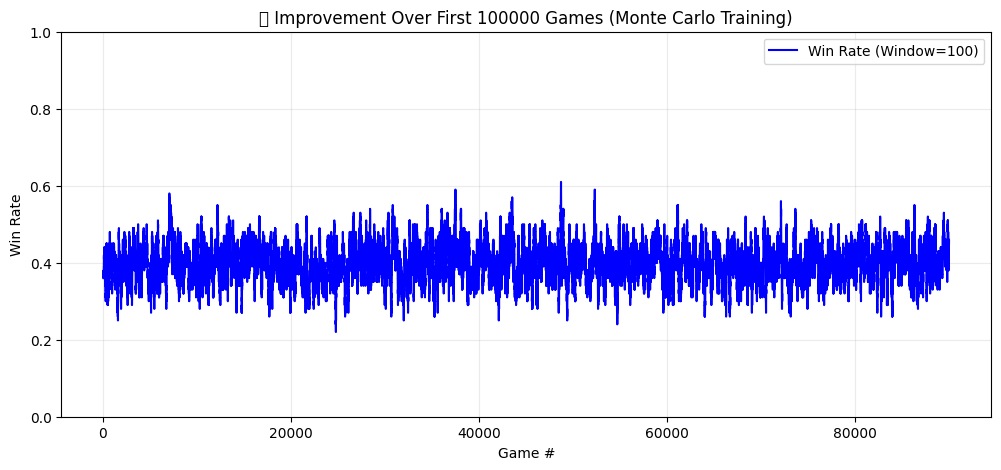

In [ ]:

#   VISUALIZING Winrate
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_sql_query("""
    SELECT game_id, final_reward
    FROM games
    ORDER BY game_id ASC
    LIMIT 90000
""", conn)

df["is_win"] = df["final_reward"].apply(lambda x: 1 if x > 0 else 0)

window_size = 100
df["moving_win_rate"] = df["is_win"].rolling(window=window_size).mean()

plt.figure(figsize=(12,5))
plt.plot(df["game_id"], df["moving_win_rate"], label=f"Win Rate (Window={window_size})", color="blue")
plt.xlabel("Game #")
plt.ylabel("Win Rate")
plt.title("📈 Improvement Over First 100000 Games (Monte Carlo Training)")
plt.ylim(0, 1)
plt.grid(alpha=0.25)
plt.legend()
plt.show()


In [ ]:

#  TOTAL BASIC STRATEGY ACCURACY (ALL LOGGED GAMES)

import pandas as pd

# Load DB
df = pd.read_sql_query("""
    SELECT player_sum, dealer_card, usable_ace, action
    FROM steps
""", conn)

# Basic Strategy
def basic_strategy(player_sum, dealer_card, usable_ace):

    if usable_ace:
        if player_sum >= 18:
            return "stand"
        return "hit"
    else:
        if player_sum >= 17:
            return "stand"
        return "hit"

#Compute the optimal action
df["optimal_action"] = df.apply(
    lambda row: basic_strategy(
        row["player_sum"],
        row["dealer_card"],
        bool(row["usable_ace"])
    ),
    axis=1
)


df["correct"] = (df["action"] == df["optimal_action"]).astype(int)
accuracy = df["correct"].mean()

print(f" TOTAL Strategy Accuracy vs Basic Strategy: {accuracy * 100:.2f}%")
print(f" Based on {len(df)} logged actions.")


 TOTAL Strategy Accuracy vs Basic Strategy: 74.36%
 Based on 182229 logged actions.


    end_game  accuracy
0       5000  0.677648
1      10000  0.728047
2      15000  0.756888
3      20000  0.764828
4      25000  0.654881
5      30000  0.685302
6      35000  0.713010
7      40000  0.733963
8      45000  0.763522
9      50000  0.752445
10     55000  0.751412
11     60000  0.755996
12     65000  0.767999
13     70000  0.799023
14     75000  0.805896
15     80000  0.791852
16     85000  0.760222
17     90000  0.739333
18     95000  0.724017
19    100000  0.741514
20    105000  0.759529
21    110000  0.758480
22    115000  0.770008
23    120000  0.732725
24    125000  0.689967
25    126922  0.731027


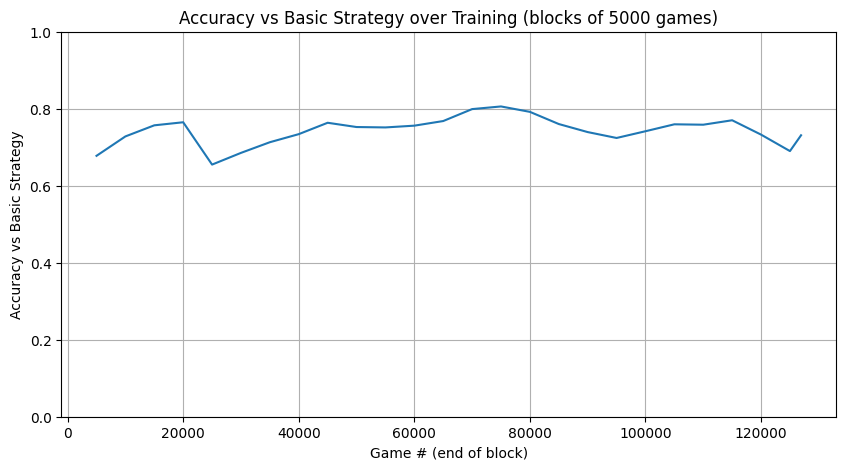

In [ ]:

#  ACCURACY VS BASIC STRATEGY IN BLOCKS OF 5000 GAMES
import pandas as pd
import matplotlib.pyplot as plt

#  basic strategy function

def basic_strategy(player_sum, dealer_card, usable_ace):

    if usable_ace:
        if player_sum >= 18:
            return "stand"
        else:
            return "hit"
    else:
        if player_sum >= 17:
            return "stand"
        else:
            return "hit"

# ---- 2. Figure out how many games you have ----
max_game_id = pd.read_sql_query("SELECT MAX(game_id) AS max_id FROM games", conn)["max_id"][0]
block_size = 5000

blocks = []
accuracies = []

#Loop over blocks of 5000 games
for start in range(1, max_game_id + 1, block_size):
    end = min(start + block_size - 1, max_game_id)

    # Get all steps for games in this block
    df = pd.read_sql_query(f"""
        SELECT game_id, player_sum, dealer_card, usable_ace, action
        FROM steps
        WHERE game_id BETWEEN {start} AND {end}
    """, conn)

    if df.empty:
        continue

    # basic strategy
    df["optimal_action"] = df.apply(
        lambda row: basic_strategy(
            row["player_sum"],
            row["dealer_card"],
            bool(row["usable_ace"])
        ),
        axis=1
    )

    # Mark correct vs incorrect
    df["correct"] = (df["action"] == df["optimal_action"]).astype(int)

    accuracy = df["correct"].mean()
    blocks.append(end)
    accuracies.append(accuracy)


acc_df = pd.DataFrame({
    "end_game": blocks,
    "accuracy": accuracies
})
print(acc_df)


plt.figure(figsize=(10,5))
plt.plot(acc_df["end_game"], acc_df["accuracy"])
plt.xlabel("Game # (end of block)")
plt.ylabel("Accuracy vs Basic Strategy")
plt.title("Accuracy vs Basic Strategy over Training (blocks of 5000 games)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


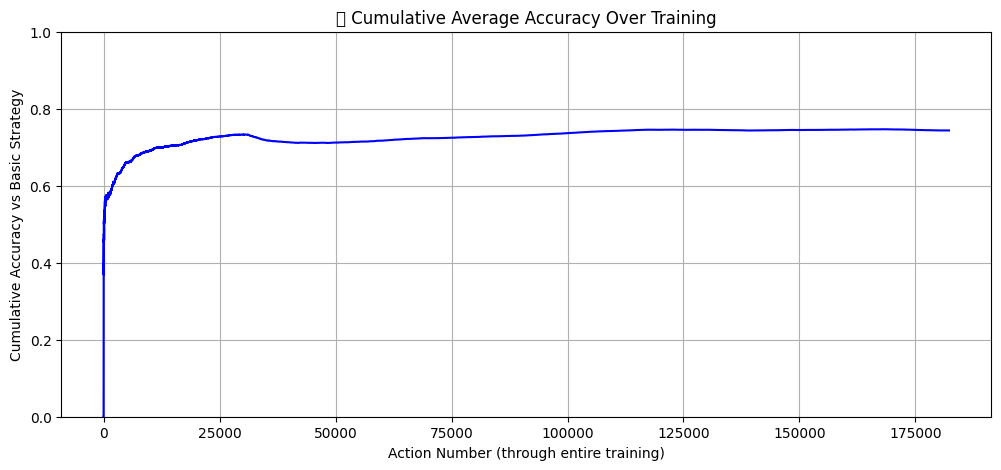

In [ ]:

#  CUMULATIVE AVERAGE ACCURACY GRAPH
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_sql_query("""
    SELECT game_id, step_num, player_sum, dealer_card, usable_ace, action
    FROM steps
    ORDER BY game_id ASC, step_num ASC
""", conn)

#ground truth
def basic_strategy(player_sum, dealer_card, usable_ace):
    # Soft hands
    if usable_ace:
        if player_sum >= 18:
            return "stand"
        return "hit"
    # Hard hands
    if player_sum >= 17:
        return "stand"
    return "hit"

#  optimal action
df["optimal_action"] = df.apply(
    lambda row: basic_strategy(
        row["player_sum"],
        row["dealer_card"],
        bool(row["usable_ace"])
    ),
    axis=1
)

#  Mark each step as correct/incorrect
df["correct"] = (df["action"] == df["optimal_action"]).astype(int)

# Compute  accuracy
df["cumulative_accuracy"] = df["correct"].expanding().mean()


plt.figure(figsize=(12,5))
plt.plot(df.index, df["cumulative_accuracy"], color="blue")
plt.xlabel("Action Number (through entire training)")
plt.ylabel("Cumulative Accuracy vs Basic Strategy")
plt.title("📈 Cumulative Average Accuracy Over Training")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


In [ ]:
#chatbot


import re
import pandas as pd

def log_episode_to_db(conn, episode):
    """
    Logs one episode into the SQLite database.

    episode: list of (state, action, reward)
        state = (player_sum, dealer_card, usable_ace)
    """
    if len(episode) == 0:
        return

    cursor = conn.cursor()

    final_reward = episode[-1][2]
    num_steps = len(episode)

    # Insert into games
    cursor.execute(
        "INSERT INTO games (final_reward, num_steps) VALUES (?, ?)",
        (final_reward, num_steps)
    )
    game_id = cursor.lastrowid

    # Insert each step
    for step_num, (state, action, reward) in enumerate(episode):
        player_sum, dealer_card, usable_ace = state
        cursor.execute("""
            INSERT INTO steps (
                game_id, step_num, player_sum, dealer_card,
                usable_ace, action, reward
            ) VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (
            game_id,
            step_num,
            player_sum,
            dealer_card,
            int(usable_ace),
            action,
            reward
        ))

    conn.commit()



def basic_strategy(player_sum, dealer_card, usable_ace):
    if usable_ace:
        if player_sum >= 18:
            return "stand"
        return "hit"
    else:
        if player_sum >= 17:
            return "stand"
        return "hit"

def check_total_accuracy(conn):
    df = pd.read_sql_query("""
        SELECT player_sum, dealer_card, usable_ace, action
        FROM steps
    """, conn)

    if df.empty:
        print("No logged steps yet to compute accuracy.")
        return

    df["optimal_action"] = df.apply(
        lambda row: basic_strategy(
            row["player_sum"],
            row["dealer_card"],
            bool(row["usable_ace"])
        ),
        axis=1
    )

    df["correct"] = (df["action"] == df["optimal_action"]).astype(int)
    accuracy = df["correct"].mean()
    print(f"\n TOTAL Strategy Accuracy vs Basic Strategy: {accuracy * 100:.2f}% "
          f"(based on {len(df)} logged actions)\n")


# ---------- Helpers for parsing user input ----------
def extract_int(text):
    """Return first integer found in the text, or None."""
    match = re.search(r"-?\d+", text)
    return int(match.group()) if match else None

def yes_no_to_bool(text):
    text = text.strip().lower()
    return text.startswith("y") or text in ("1", "true")


# ---------- Chatbot: play one blackjack hand ----------
def play_blackjack_hand(policy, conn):
    print("\n Let's enter a blackjack hand.")

    # Dealer's visible card
    while True:
        dealer_input = input("What is the dealer's visible card? (1–10) ")
        dealer_card = extract_int(dealer_input)
        if dealer_card is not None and 1 <= dealer_card <= 10:
            break
        print("Please enter a number between 1 and 10 (e.g., 6).")

    # Player's hand total
    while True:
        player_input = input("What is your current hand total? (e.g., 15) ")
        player_sum = extract_int(player_input)
        if player_sum is not None and 4 <= player_sum <= 21:
            break
        print("Please enter a reasonable total between 4 and 21.")

    # Usable ace
    usable_input = input(
        "Do you have a usable ace (an Ace counting as 11 without busting)? (yes/no) "
    )
    usable_ace = yes_no_to_bool(usable_input)

    state = (player_sum, dealer_card, usable_ace)
    episode = []

    while True:
        # Recommend an action from the learned policy
        if state in policy:
            recommended = policy[state]
        else:
            recommended = basic_strategy(*state)  # fallback
        print(f"\n Bot recommends: {recommended.upper()}")

        # Ask what action the user actually takes
        action_input = input("What action did you take? (hit/stand) ").strip().lower()
        if action_input.startswith("h"):
            action = "hit"
        elif action_input.startswith("s"):
            action = "stand"
        else:
            print("Please answer with 'hit' or 'stand'.")
            continue

        # If hit: ask new total or bust
        if action == "hit":
            # Reward is 0 for intermediate steps (game not over yet or we bust)
            outcome_input = input(
                "After hitting, what is your new hand total? "
                "(enter a number, or type 'bust') "
            ).strip().lower()

            if "bust" in outcome_input:
                reward = -1.0
                episode.append((state, action, reward))
                print(" You busted. Logging this game.")
                break
            else:
                new_total = extract_int(outcome_input)
                if new_total is None or new_total > 31:
                    print("Couldn't understand that total, assuming you busted.")
                    reward = -1.0
                    episode.append((state, action, reward))
                    break
                # Non-terminal step: reward 0, update state and continue
                reward = 0.0
                episode.append((state, action, reward))

                # Ask if we still have a usable ace
                usable_input = input(
                    "After hitting, do you still have a usable ace? (yes/no) "
                )
                usable_ace = yes_no_to_bool(usable_input)

                state = (new_total, dealer_card, usable_ace)
                continue

        # If stand: ask for final outcome (win/lose/draw)
        if action == "stand":
            outcome = input("What was the outcome? (win / lose / draw) ").strip().lower()
            if "win" in outcome:
                reward = +1.0
            elif "lose" in outcome or "lost" in outcome:
                reward = -1.0
            else:
                reward = 0.0  # treat anything else as draw

            episode.append((state, action, reward))
            print(" Outcome recorded. Logging this game.")
            break

    # Log this human-played episode to DB
    log_episode_to_db(conn, episode)
    print(" Game saved to database.\n")


#  Main chatbot loop
def blackjack_chatbot(policy, conn):
    print("Blackjack assistant activated.")
    print("Options: play a blackjack hand, check accuracy, or quit.\n")

    # Added: "play" and "start" keywords
    play_keywords = ("game", "blackjack", "hand", "play", "start")
    acc_keywords = ("accuracy", "correct", "incorrect")
    quit_keywords = ("quit", "exit", "done")

    while True:
        user_input = input(
            "Menu: would you like to input a blackjack hand, check accuracy, or quit?\n> "
        ).strip().lower()

        if any(k in user_input for k in quit_keywords):
            print(" Exiting blackjack assistant. Goodbye!")
            break
        elif any(k in user_input for k in acc_keywords):
            check_total_accuracy(conn)
        elif any(k in user_input for k in play_keywords):
            play_blackjack_hand(policy, conn)
        else:
            print("I didn't catch that. Try mentioning 'play', 'hand', 'accuracy', or 'quit'.")


# Run the chatbot
blackjack_chatbot(policy, conn)


Blackjack assistant activated.
Options: play a blackjack hand, check accuracy, or quit.

Menu: would you like to input a blackjack hand, check accuracy, or quit?
> blackjack

 Let's enter a blackjack hand.
What is the dealer's visible card? (1–10) 7
What is your current hand total? (e.g., 15) 12
Do you have a usable ace (an Ace counting as 11 without busting)? (yes/no) no

 Bot recommends: HIT
What action did you take? (hit/stand) hit
After hitting, what is your new hand total? (enter a number, or type 'bust') 18
After hitting, do you still have a usable ace? (yes/no) no

 Bot recommends: STAND
What action did you take? (hit/stand) stand 
What was the outcome? (win / lose / draw) win
 Outcome recorded. Logging this game.
 Game saved to database.

Menu: would you like to input a blackjack hand, check accuracy, or quit?
> quit
 Exiting blackjack assistant. Goodbye!
